In [32]:
import pandas as pd

In [33]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
# from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install spreadsheets and import authentication module.
USER_RATINGS = True

In [34]:
users = pd.read_csv('userinfo.csv')  # users : userid, sex, age, occupation, zip code
users.head()                         # users : id, email, Caffeine(디카페인-1), CoffeeType(블렌드-1), CupNoteCategories, Body, Sourness, Sweetness, Bitterness

,id,email,Caffeine,CoffeeType,CupNoteCategories,Body,Sourness,Sweetness,Bitterness
0,3,hwhj1214@naver.com,0,1,"['초콜릿', '고소함']",4,1,4,2
1,4,syjflora@gmail.com,1,0,"['초콜릿', '달콤함', '고소함']",3,3,3,3
2,5,aiwithsj@gmail.com,0,0,['고소함'],4,2,3,3
3,6,katherine@gmail.com,0,0,['고소함'],5,1,1,4
4,7,seunghyun@test.com,0,1,"['달콤함', '고소함']",3,1,5,2


In [35]:
coffees = pd.read_csv('mysite/data/features.csv')  # movies : movieid, released date 등등
coffees.head(3)                                    # coffees : id, body, sweet, ..., 지속가능성, 향 카테고리등 

,id,body,sour,sweet,bitter,caf,blend,single,지속가능성_0,지속가능성_공정무역,...,로스팅 포인트_라이트미디엄,로스팅 포인트_미디엄,로스팅 포인트_미디엄다크,꽃,과일,허브,달콤함,고소함,향료,초콜릿
0,2,2,3,5,1,1,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
1,3,4,2,4,1,1,1,0,0,1,...,0,0,1,0,1,0,0,1,0,1
2,5,4,2,4,3,1,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [36]:
new_id = pd.read_csv('mysite/data/coffeeDB.csv')
new_id.head(1)

,new_id,id,이름,로스터리ID,커피 소개,타입,로스팅 포인트,지속가능성,컵 노트,바디감,...,원재료 및 함량,제품문의 관련 주소 및 전화번호,price,꽃,과일,허브,달콤함,고소함,향료,초콜릿
0,0,2,나탈리,60,잘 익은 딸기를 베어 문듯한 단맛과 적당한 산미의 조화를 이루는 와인의 풍미를 느낄...,블렌드,미디엄,공정무역,"['딸기', '와인', '화이트 초콜릿']",2,...,"원두 커피(엘살바도르 30%, 파푸아뉴기니 40%, 코스타리카 30%)",코케 고객센터 070-4647-1868,16000,0,1,0,0,0,0,1


In [37]:
coffees = new_id[['new_id', 'id']].merge(coffees, on = 'id')
coffees.head(2)

,new_id,id,body,sour,sweet,bitter,caf,blend,single,지속가능성_0,...,로스팅 포인트_라이트미디엄,로스팅 포인트_미디엄,로스팅 포인트_미디엄다크,꽃,과일,허브,달콤함,고소함,향료,초콜릿
0,0,2,2,3,5,1,1,1,0,0,...,0,1,0,0,1,0,0,0,0,1
1,1,3,4,2,4,1,1,1,0,0,...,0,0,1,0,1,0,0,1,0,1


In [38]:
ratings = pd.read_csv('ratings.csv')  # userid, movieid, ratings, unixtimestamp(?) 
ratings.head(3)                       # (rating)id, email, Stars, created_date, CoffeeID_id 

,id,email,Stars,created_date,CoffeeID_id
0,21,hwhj1214@naver.com,4,2023-11-15 12:45:57.508133,173
1,22,hwhj1214@naver.com,5,2023-11-15 12:45:57.511119,1201
2,23,hwhj1214@naver.com,1,2023-11-15 12:45:57.513877,1494


***
Coffee는 new_id 지정, 회원은 id 0으로 시작하게 다시 지정해야함
- ratings : email을 통해 user id로 변환
- CoffeeID_id : 새로운 아이디로 변환
***

In [39]:
users = users.reset_index(drop=False)  # 0부터 시작하는 index 생성
users.head(2)

,index,id,email,Caffeine,CoffeeType,CupNoteCategories,Body,Sourness,Sweetness,Bitterness
0,0,3,hwhj1214@naver.com,0,1,"['초콜릿', '고소함']",4,1,4,2
1,1,4,syjflora@gmail.com,1,0,"['초콜릿', '달콤함', '고소함']",3,3,3,3


In [40]:
test = ratings.copy()
test['userid'] = test.merge(users, how='left', left_on='email', right_on='email')['index']
test['coffeeid'] = test.merge(coffees, how='left', left_on='CoffeeID_id', right_on='id')['new_id']

test = test[['id', 'userid', 'email','CoffeeID_id', 'coffeeid', 'Stars', 'created_date']]
test.head(2)

,id,userid,email,CoffeeID_id,coffeeid,Stars,created_date
0,21,0,hwhj1214@naver.com,173,60,4,2023-11-15 12:45:57.508133
1,22,0,hwhj1214@naver.com,1201,149,5,2023-11-15 12:45:57.511119


In [41]:
# userid, movieid, ratings, unixtimestamp(?) 
ratings = test[['userid', 'coffeeid', 'Stars', 'created_date']]
ratings.head(3)

,userid,coffeeid,Stars,created_date
0,0,60,4,2023-11-15 12:45:57.508133
1,0,149,5,2023-11-15 12:45:57.511119
2,0,177,1,2023-11-15 12:45:57.513877


In [42]:
users = users.rename(columns={"index":"userid"})
users = users.drop(columns='id')
users.head(2)

,userid,email,Caffeine,CoffeeType,CupNoteCategories,Body,Sourness,Sweetness,Bitterness
0,0,hwhj1214@naver.com,0,1,"['초콜릿', '고소함']",4,1,4,2
1,1,syjflora@gmail.com,1,0,"['초콜릿', '달콤함', '고소함']",3,3,3,3


In [43]:
coffees = coffees.rename(columns={"new_id":"coffeeid"}).drop(columns='id')
coffees.head(2)

,coffeeid,body,sour,sweet,bitter,caf,blend,single,지속가능성_0,지속가능성_공정무역,...,로스팅 포인트_라이트미디엄,로스팅 포인트_미디엄,로스팅 포인트_미디엄다크,꽃,과일,허브,달콤함,고소함,향료,초콜릿
0,0,2,3,5,1,1,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
1,1,4,2,4,1,1,1,0,0,1,...,0,0,1,0,1,0,0,1,0,1


In [44]:
#### 전처리로 id가 0부터 시작 ####
coffeelens = ratings.merge(coffees, on='coffeeid').merge(users, on='userid').drop(columns='email')  # ratings.merge(movies, on='movie_id').merge(users, on='user_id')
coffeelens.head(2)

,userid,coffeeid,Stars,created_date,body,sour,sweet,bitter,caf,blend,...,고소함,향료,초콜릿,Caffeine,CoffeeType,CupNoteCategories,Body,Sourness,Sweetness,Bitterness
0,0,60,4,2023-11-15 12:45:57.508133,3,3,4,2,1,1,...,0,0,1,0,1,"['초콜릿', '고소함']",4,1,4,2
1,0,149,5,2023-11-15 12:45:57.511119,3,1,3,4,1,1,...,1,0,0,0,1,"['초콜릿', '고소함']",4,1,4,2


In [45]:
coffeelens.columns

Index(['userid', 'coffeeid', 'Stars', 'created_date', 'body', 'sour', 'sweet',
       'bitter', 'caf', 'blend', 'single', '지속가능성_0', '지속가능성_공정무역',
       '지속가능성_유기농', '지속가능성_직접무역', '로스팅 포인트_다크', '로스팅 포인트_라이트',
       '로스팅 포인트_라이트미디엄', '로스팅 포인트_미디엄', '로스팅 포인트_미디엄다크', '꽃', '과일', '허브',
       '달콤함', '고소함', '향료', '초콜릿', 'Caffeine', 'CoffeeType',
       'CupNoteCategories', 'Body', 'Sourness', 'Sweetness', 'Bitterness'],
      dtype='object')

In [46]:
users = users.drop(columns='email')
users.head()

,userid,Caffeine,CoffeeType,CupNoteCategories,Body,Sourness,Sweetness,Bitterness
0,0,0,1,"['초콜릿', '고소함']",4,1,4,2
1,1,1,0,"['초콜릿', '달콤함', '고소함']",3,3,3,3
2,2,0,0,['고소함'],4,2,3,3
3,3,0,0,['고소함'],5,1,1,4
4,4,0,1,"['달콤함', '고소함']",3,1,5,2


In [47]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

# II. Preliminaries

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.

In [48]:
# Tensorflow2로 MF 구현

import tensorflow as tf
from tensorflow import keras
from keras.models import Model

from keras.layers import Input, Embedding, Flatten, dot

In [49]:
users.shape[0], coffees.shape[0]  # user 46명, 커피 559개

(46, 559)

In [50]:
n_latent_factors = 15 # user와 movie embedding의 차원수

user_input = Input(shape=[1], name='user')
coffee_input = Input(shape=[1], name='coffee')

user_embedding = Embedding(input_dim=users.shape[0] # 46
                           , output_dim = n_latent_factors # 30
                           , name='user_embedding'
                           )(user_input)

coffee_embedding = Embedding(input_dim=coffees.shape[0] # 559
                           , output_dim = n_latent_factors # 30
                           , name='coffee_embedding'
                           )(coffee_input)

user_vec = Flatten(name='flatten_users')(user_embedding) # 1차원 배열로 변환
coffee_vec = Flatten(name='flatten_coffees')(coffee_embedding) # 1차원 배열로 변환

product = dot([coffee_vec, user_vec], axes=1) # 평점
model = Model(inputs=[user_input, coffee_input], outputs=product) # user와 movie가 주어졌을 때, 평점을 예측하는 모델

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 coffee (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 coffee_embedding (Embeddin  (None, 1, 15)                8385      ['coffee[0][0]']              
 g)                                                                                               
                                                                                                  
 user_embedding (Embedding)  (None, 1, 15)                690       ['user[0][0]']            

In [52]:
# user의 수 * 30
46 * 15

690

In [53]:
# coffee의 수 * 30
559 * 15

8385

In [54]:
# compile
model.compile(optimizer='adam', loss='mse')

In [55]:
ratings.head()

,userid,coffeeid,Stars,created_date
0,0,60,4,2023-11-15 12:45:57.508133
1,0,149,5,2023-11-15 12:45:57.511119
2,0,177,1,2023-11-15 12:45:57.513877
3,0,205,4,2023-11-15 12:45:57.515229
4,0,215,5,2023-11-15 12:45:57.518882


In [56]:
ratings['userid'] = ratings['userid'].astype(int)
ratings['coffeeid'] = ratings['coffeeid'].astype(int)

train_ratings, test_ratings = split_dataframe(ratings)
train_ratings.shape, test_ratings.shape

C:\Users\Playdata\AppData\Local\Temp\ipykernel_14144\654883017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['userid'] = ratings['userid'].astype(int)
C:\Users\Playdata\AppData\Local\Temp\ipykernel_14144\654883017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['coffeeid'] = ratings['coffeeid'].astype(int)


((414, 4), (46, 4))

In [57]:
train_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 0 to 458
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   userid        414 non-null    int32 
 1   coffeeid      414 non-null    int32 
 2   Stars         414 non-null    int64 
 3   created_date  414 non-null    object
dtypes: int32(2), int64(1), object(1)
memory usage: 12.9+ KB


In [58]:
test_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46 entries, 186 to 172
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   userid        46 non-null     int32 
 1   coffeeid      46 non-null     int32 
 2   Stars         46 non-null     int64 
 3   created_date  46 non-null     object
dtypes: int32(2), int64(1), object(1)
memory usage: 1.4+ KB


In [59]:
train_ratings.shape[0]

414

In [60]:
history = model.fit(x=[train_ratings['userid'], train_ratings['coffeeid']],
                    y=train_ratings['Stars'], epochs=500,
                    validation_data=([test_ratings['userid'], test_ratings['coffeeid'] ],
                                     test_ratings['Stars']),
                    verbose=1, batch_size=train_ratings.shape[0])

Epoch 1/500

1/1 [==============================] - ETA: 0s - loss: 11.7525

1/1 [==============================] - 2s 2s/step - loss: 11.7525 - val_loss: 12.0845
Epoch 2/500
1/1 [==============================] - 0s 89ms/step - loss: 11.7498 - val_loss: 12.0843
Epoch 3/500
1/1 [==============================] - 0s 59ms/step - loss: 11.7471 - val_loss: 12.0841
Epoch 4/500
1/1 [==============================] - 0s 48ms/step - loss: 11.7444 - val_loss: 12.0840
Epoch 5/500
1/1 [==============================] - 0s 48ms/step - loss: 11.7417 - val_loss: 12.0838
Epoch 6/500
1/1 [==============================] - 0s 47ms/step - loss: 11.7389 - val_loss: 12.0837
Epoch 7/500
1/1 [==============================] - 0s 47ms/step - loss: 11.7361 - val_loss: 12.0835
Epoch 8/500
1/1 [==============================] - 0s 107ms/step - loss: 11.7332 - val_loss: 12.0834
Epoch 9/500
1/1 [==============================] - 0s 59ms/step - loss: 11.7303 - val_loss: 12.0832
Epoch 10/500
1/1 [==============================] - 0s 54ms/step - loss: 11.7273 - val_loss: 12.0830
Epoch 11/500

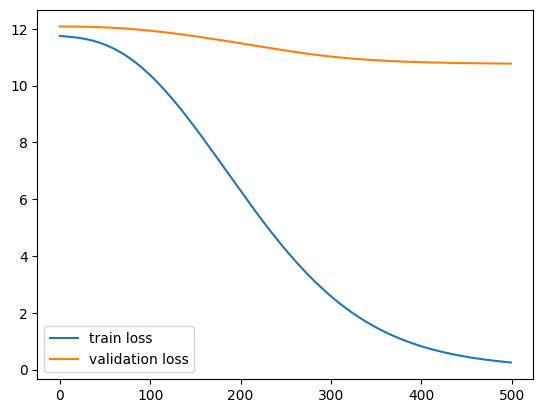

In [83]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'validation loss'])
# plt.ylim([0,4])
plt.show()

*** 
#### model save as pickle file
***

In [78]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [79]:
new_model = tf.keras.models.load_model('saved_model')

# Check its architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 coffee (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 coffee_embedding (Embeddin  (None, 1, 15)                8385      ['coffee[0][0]']              
 g)                                                                                               
                                                                                                  
 user_embedding (Embedding)  (None, 1, 15)                690       ['user[0][0]']            

# IV. Inspecting the Embeddings

In this section, we take a closer look at the learned embeddings, by
- computing your recommendations
- looking at the nearest neighbors of some movies,
- looking at the norms of the movie embeddings,
- visualizing the embedding in a projected embedding space.

### Exercise 5: Write a function that computes the scores of the candidates
We start by writing a function that, given a query embedding $u \in \mathbb R^d$ and item embeddings $V \in \mathbb R^{N \times d}$, computes the item scores.

As discussed in the lecture, there are different similarity measures we can use, and these can yield different results. We will compare the following:
- dot product: the score of item j is $\langle u, V_j \rangle$.
- cosine: the score of item j is $\frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$.

Hints:
- you can use [`np.dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) to compute the product of two np.Arrays.
- you can use [`np.linalg.norm`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.norm.html) to compute the norm of a np.Array.

In [62]:
#@title Solution
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [63]:
# @title User recommendations and nearest neighbors (run this cell)
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6, userid=570):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["userid"][userid], model.embeddings["coffeeid"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'coffeeid': coffees['coffeeid'],
        'caf': coffees['caf'],
        'sour': coffees['sour'],
        'sweet': coffees['sweet'],
        'body': coffees['body'],
        'bitter': coffees['bitter']
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_coffees = ratings[ratings.userid == str(userid)]["coffeeid"].values
      df = df[df.coffeeid.apply(lambda coffeeid: coffeeid not in rated_coffees)]
    return (df.sort_values([score_key], ascending=False).head(k))

rec

In [64]:
coffeelens.loc[coffeelens['userid'] == 3, :]

,userid,coffeeid,Stars,created_date,body,sour,sweet,bitter,caf,blend,...,고소함,향료,초콜릿,Caffeine,CoffeeType,CupNoteCategories,Body,Sourness,Sweetness,Bitterness
50,3,382,1,2023-11-15 12:46:18.659999,3,4,4,2,1,0,...,0,0,0,0,0,['고소함'],5,1,1,4
51,3,90,1,2023-11-15 12:46:18.641231,3,3,4,1,1,1,...,0,0,0,0,0,['고소함'],5,1,1,4
52,3,141,1,2023-11-15 12:46:18.645059,2,4,4,1,1,1,...,0,0,0,0,0,['고소함'],5,1,1,4
53,3,315,5,2023-11-15 12:46:18.649072,4,1,5,4,0,0,...,0,0,0,0,0,['고소함'],5,1,1,4
54,3,345,1,2023-11-15 12:46:18.652766,4,4,3,4,1,1,...,0,0,0,0,0,['고소함'],5,1,1,4
55,3,380,1,2023-11-15 12:46:18.656392,4,3,4,3,1,0,...,0,0,0,0,0,['고소함'],5,1,1,4
56,3,436,5,2023-11-15 12:46:18.664242,3,1,5,3,1,1,...,0,0,0,0,0,['고소함'],5,1,1,4
57,3,439,1,2023-11-15 12:46:18.668074,3,4,4,1,1,1,...,0,0,0,0,0,['고소함'],5,1,1,4
58,3,454,5,2023-11-15 12:46:18.671912,4,2,4,2,1,1,...,0,0,0,0,0,['고소함'],5,1,1,4
59,3,472,5,2023-11-15 12:46:18.675619,4,1,4,3,1,1,...,0,0,0,0,0,['고소함'],5,1,1,4


- tf2로 학습된 embedding을 model의 변수로 입력

In [65]:
model.embeddings = {
    'userid': model.get_layer('user_embedding').weights[0].numpy(), # U (943, 30)
    'coffeeid': model.get_layer('coffee_embedding').weights[0].numpy() # V (1682, 30)
}

> 결과 확인

In [66]:
user_recommendations(model, measure=COSINE, k=5, userid=3, exclude_rated=True)

,cosine score,coffeeid,caf,sour,sweet,body,bitter
472,0.965,472,1,1,4,4,3
436,0.859,436,1,1,5,3,3
315,0.797,315,0,1,5,4,4
454,0.775,454,1,2,4,4,2
152,0.716,152,1,2,3,3,2


In [67]:
users[users['userid']==3]

,userid,Caffeine,CoffeeType,CupNoteCategories,Body,Sourness,Sweetness,Bitterness
3,3,0,0,['고소함'],5,1,1,4


In [68]:
coffees[coffees['coffeeid']==141]

,coffeeid,body,sour,sweet,bitter,caf,blend,single,지속가능성_0,지속가능성_공정무역,...,로스팅 포인트_라이트미디엄,로스팅 포인트_미디엄,로스팅 포인트_미디엄다크,꽃,과일,허브,달콤함,고소함,향료,초콜릿
141,141,2,4,4,1,1,1,0,1,0,...,1,0,0,0,1,0,1,0,0,0


NB

In [73]:

def coffee_neighbors(model, measure=DOT, k=6, coffeeid=2):
  # Search for movie ids that match the given substring.
  # ids =  coffees[cofees['coffeeid'].str.contains(title_substring)].index.values
  # titles = coffees.iloc[ids]['title'].values
  # if len(titles) == 0:
  #   raise ValueError("Found no movies with title %s" % title_substring)
  # print("Nearest neighbors of : %s." % titles[0])
  # if len(titles) > 1:
  #   print("[Found more than one matching movie. Other candidates: {}]".format(
  #       ", ".join(titles[1:])))
  # movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["coffeeid"][coffeeid], model.embeddings["coffeeid"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
        'coffeeid': coffees['coffeeid'],
        'caf': coffees['caf'],
        'sour': coffees['sour'],
        'sweet': coffees['sweet'],
        'body': coffees['body'],
        'bitter': coffees['bitter']
  })
  return (df.sort_values([score_key], ascending=False).head(k))

In [74]:
coffee_neighbors(model, DOT, 3)

,dot score,coffeeid,caf,sour,sweet,body,bitter
453,4.134,453,1,1,5,5,2
2,3.628,2,1,2,4,4,3
471,3.052,471,1,3,3,4,3
